In [1]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import PIL.Image as Image
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import xml.etree.ElementTree as ET

from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/raymondlab/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/raymondlab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raymondlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# get data
dfs = []
for city_csv in os.listdir('data'):
    temp_df = pd.read_csv(os.path.join('data', city_csv))
    temp_df['city'] = city_csv.replace('.csv', '')
    dfs.append(temp_df)
    
df = pd.concat(dfs, ignore_index=True)

In [3]:
# model configuration
model_id = "Qwen3-VL-30B-A3B-Instruct"

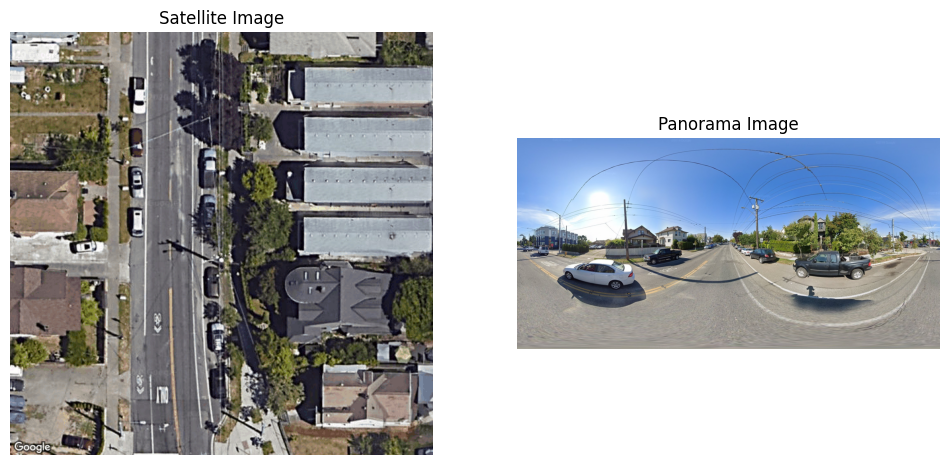

Satellite Image Generated Text:
 <satellite_scene>
  <landmarks>road, parked cars, residential houses, commercial buildings, trees, sidewalks</landmarks>
  <visual_attributes>asphalt road with white lane markings, rectangular grey rooftops, brown and grey rooftops, green tree canopies, white and grey vehicles, white crosswalk</visual_attributes>
  <spatial_relations>road runs vertically through the center, houses are on both sides of the road, commercial buildings are on the right side of the road, trees are scattered along the sidewalks and between properties, parked cars are on both sides of the road</spatial_relations>
  <cardinal_orientation>road runs north-south</cardinal_orientation>
  <geometric_features>grid-like street layout, straight road with minor curves, rectangular properties, linear arrangement of buildings and trees along the road</geometric_features>
</satellite_scene>

Panorama Image Generated Text:
 <ground_scene>
  <landmarks>road, cars, trucks, houses, trees, util

In [4]:
def process_generated_texts(satellite_path, panorama_path, display=True):
    # image and text display function
    if display:
        # subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        satellite_image = Image.open(satellite_path)
        axs[0].imshow(satellite_image)
        axs[0].axis('off')
        axs[0].set_title('Satellite Image')

        panorama_image = Image.open(panorama_path)
        axs[1].imshow(panorama_image)
        axs[1].axis('off')
        axs[1].set_title('Panorama Image')
        plt.show()

    city = satellite_path.split('/')[1]
    image_type = satellite_path.split('/')[2]

    file_path = os.path.join("results", image_type, model_id, city, image_type, satellite_path.split('/')[-1])

    with open(file_path.replace('.png', '.txt'), 'r') as f:
        sate_text = f.read()

    city = panorama_path.split('/')[1]
    image_type = panorama_path.split('/')[2]

    file_path = os.path.join("results",image_type, model_id, city, image_type, panorama_path.split('/')[-1])

    with open(file_path.replace('.jpg', '.txt'), 'r') as f:
        pano_text = f.read()
    if display:
        print("Satellite Image Generated Text:\n", sate_text)
        print("\nPanorama Image Generated Text:\n", pano_text)
            
    return ET.fromstring(sate_text), ET.fromstring(pano_text)

# Example usage of this function
satellite = os.path.join('VIGOR', df['city'].iloc[0], 'satellite', df['satellite'].iloc[0])
panorama = os.path.join('VIGOR', df['city'].iloc[0], 'panorama', df['panorama'].iloc[0])

sate_text, pano_text = process_generated_texts(satellite, panorama)

In [5]:
satellite_keys = ['landmarks', 'visual_attributes', 'spatial_relations', 'cardinal_orientation', 'geometric_features']
panorama_keys = ['landmarks', 'visual_attributes', 'spatial_relations', 'geometry', 'environmental_context']

In [6]:
# lemmatization function
def preprocessing_lemmatizer(generated_text, keys):
    data = {}
    for key in keys:
        text = generated_text.find(key).text
        # https://www.geeksforgeeks.org/nlp/removing-stop-words-nltk-python/
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        tokens = word_tokenize(text)

        filtered_tokens = [word.strip() for word in tokens if word not in stop_words]
        filtered_tokens = [word for word in filtered_tokens if word.isalnum()]
        lemmatizer = WordNetLemmatizer()

        tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]
        data[key] = " ".join(tokens)
    return data
sate_data = preprocessing_lemmatizer(sate_text, satellite_keys)
pano_data = preprocessing_lemmatizer(pano_text, panorama_keys)


In [7]:
sate_data

{'landmarks': 'road parked car residential house commercial building tree sidewalk',
 'visual_attributes': 'asphalt road white lane marking rectangular grey rooftop brown grey rooftop green tree canopy white grey vehicle white crosswalk',
 'spatial_relations': 'road run vertically center house side road commercial building right side road tree scattered along sidewalk property parked car side road',
 'cardinal_orientation': 'road run',
 'geometric_features': 'street layout straight road minor curve rectangular property linear arrangement building tree along road'}

In [8]:
city_dict = {city: None for city in df['city'].unique()}

for city in df['city'].unique():
    satellite_all = {satellite_keys[i]: [] for i in range(len(satellite_keys))}
    panorama_all = {panorama_keys[i]: [] for i in range(len(panorama_keys))}
    # vectorization for each image type
    for i, row in df[df['city'] == city].iterrows():

        satellite = os.path.join('VIGOR', row['city'], 'satellite', row['satellite'])
        panorama = os.path.join('VIGOR', row['city'], 'panorama', row['panorama'])

        try:
            sate_text, pano_text = process_generated_texts(satellite, panorama, display=False)
            sate_data = preprocessing_lemmatizer(sate_text, satellite_keys)

            pano_data = preprocessing_lemmatizer(pano_text, panorama_keys)

            for key in satellite_keys:
                satellite_all[key].append(sate_data[key])  
            for key in panorama_keys:
                panorama_all[key].append(pano_data[key])  
        except Exception as e:
            print(f"Error processing {satellite} and {panorama}: {e}")  
    city_dict[city] = {'satellite': satellite_all, 'panorama': panorama_all}

Error processing VIGOR/Seattle/satellite/satellite_47.616701969022145_-122.33797411153729.png and VIGOR/Seattle/panorama/Dm-0JM_o96xm2uc2kxhBKQ,47.616787,-122.338181,.jpg: mismatched tag: line 7, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.606203650537736_-122.33262322499239.png and VIGOR/Seattle/panorama/wfFlnYrx-TaXDsd9d1s-aA,47.606145,-122.332845,.jpg: mismatched tag: line 7, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.61342124449577_-122.33067744806698.png and VIGOR/Seattle/panorama/s58ZEUG1B3XICw8q6Xabjg,47.613581,-122.330568,.jpg: mismatched tag: line 7, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.60029834639026_-122.29127546532725.png and VIGOR/Seattle/panorama/Co4HJHq4QieDPqnSQEh_JA,47.600223,-122.291256,.jpg: mismatched tag: line 7, column 2
Error processing VIGOR/Seattle/satellite/satellite_47.605219433179826_-122.33651477884322.png and VIGOR/Seattle/panorama/1HdIZlsseEtkADFXBW7QLQ,47.605161,-122.336749,.jpg: mismatched

In [9]:
for city in city_dict:
    print(f"City: {city}")
    satellite_all = city_dict[city]['satellite']['landmarks']
    panorama_all = city_dict[city]['panorama']['landmarks']
    print(f"Correct Formatting: {len(satellite_all)}/2500")

City: Seattle
Correct Formatting: 2422/2500
City: NewYork
Correct Formatting: 2387/2500
City: SanFrancisco
Correct Formatting: 2373/2500
City: Chicago
Correct Formatting: 2432/2500


In [10]:
def bag_of_words(texts, top_n=20):
    
    bow_vectorizer = CountVectorizer(max_features=5000)
    bow_matrix = bow_vectorizer.fit_transform(texts)
    bow_words = bow_vectorizer.get_feature_names_out()
    bow_counts = bow_matrix.toarray()
    
    # Sum frequencies
    frequency = bow_counts.sum(axis=0)

    # Sort by frequency (descending) and pick top_n
    top_indices = np.argsort(frequency)[::-1][:top_n]
    top_words = [(bow_words[i], frequency[i]) for i in top_indices]

    return top_words

In [11]:
common_landmarks = None
os.system("rm -r results/satellite_result")
os.system("mkdir results/satellite_result")

os.system("mkdir results/satellite_result/count_vectorizer")
for city in city_dict:
    satellite_all = city_dict[city]['satellite']
    os.system(f"mkdir results/satellite_result/count_vectorizer/{city}")
    for key in satellite_keys:
        top_words = bag_of_words(satellite_all[key], top_n=10)
        with open(f'results/satellite_result/count_vectorizer/{city}/{key}.txt', 'w') as f:
            words = []
            for word, freq in top_words:
                print(f"{word}: {freq}", file=f)
                words.append(word)
            if key == 'landmarks':
                if common_landmarks is None:
                    common_landmarks = set(words)
                else:
                    common_landmarks = common_landmarks.intersection(set(words))


        

In [12]:
city_satellite_landmarks = {}
# get values
for city in city_dict:
    satellite_all = city_dict[city]['satellite']['landmarks']
    top_words = bag_of_words(satellite_all, top_n=10)
    words = {}
    for word, freq in top_words:
        if word in common_landmarks:
            words[word] = freq
    city_satellite_landmarks[city] = words
city_satellite_landmarks

{'Seattle': {'tree': np.int64(2077),
  'road': np.int64(1728),
  'building': np.int64(1350),
  'car': np.int64(1177),
  'parked': np.int64(976),
  'sidewalk': np.int64(851)},
 'NewYork': {'building': np.int64(2599),
  'tree': np.int64(1617),
  'road': np.int64(1375),
  'car': np.int64(1178),
  'parked': np.int64(952),
  'sidewalk': np.int64(861)},
 'SanFrancisco': {'building': np.int64(2171),
  'tree': np.int64(1899),
  'road': np.int64(1754),
  'car': np.int64(1614),
  'parked': np.int64(1391),
  'sidewalk': np.int64(815)},
 'Chicago': {'building': np.int64(2207),
  'tree': np.int64(1919),
  'road': np.int64(1763),
  'car': np.int64(1035),
  'sidewalk': np.int64(960),
  'parked': np.int64(715)}}

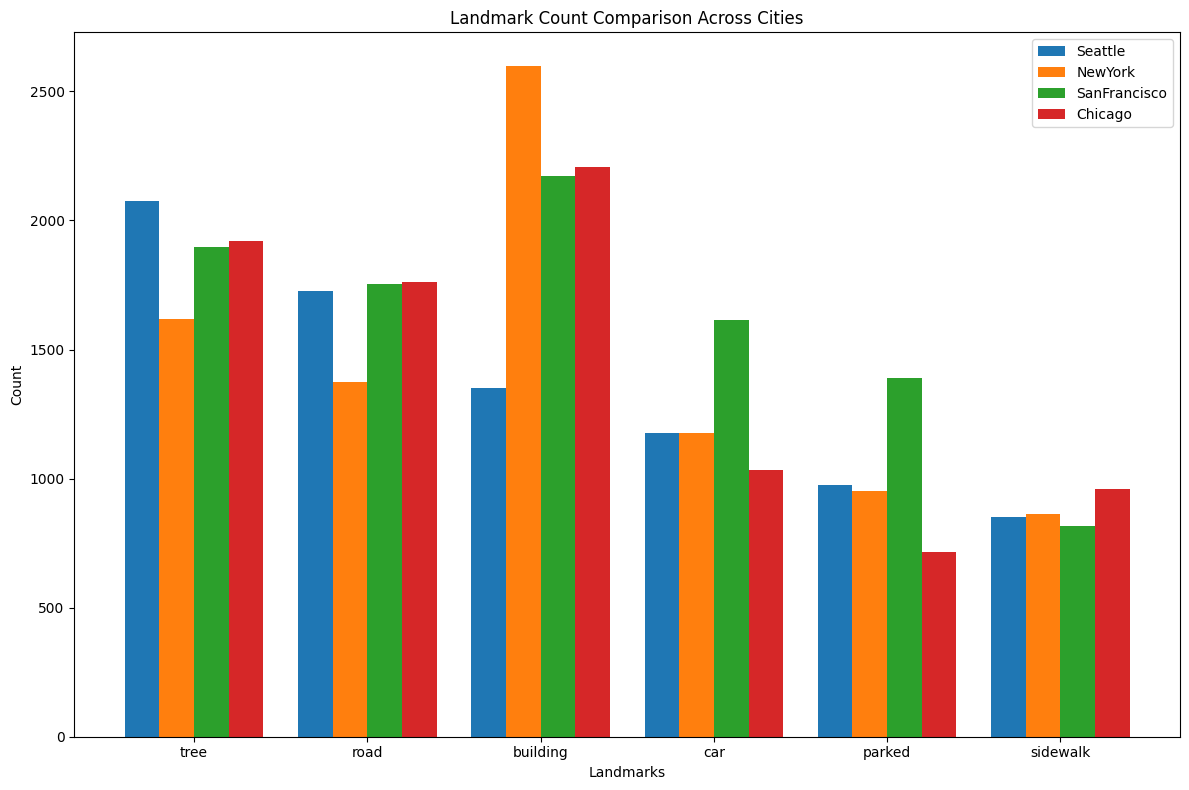

In [13]:

cities = list(city_satellite_landmarks.keys())
landmarks = list(next(iter(city_satellite_landmarks.values())).keys())

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(landmarks))

for i, city in enumerate(cities):
    counts = [city_satellite_landmarks[city][landmark] for landmark in landmarks]
    ax.bar(index + i * bar_width, counts, width=bar_width, label=city)

ax.set_xlabel('Landmarks')
ax.set_ylabel('Count')
ax.set_title('Landmark Count Comparison Across Cities')
ax.set_xticks(index + bar_width * (len(cities) - 1) / 2)
ax.set_xticklabels(landmarks)
ax.legend()

plt.tight_layout()
plt.show()

In [14]:


common_landmarks = None
os.system("rm -r results/panorama_result")
os.system("mkdir results/panorama_result")
os.system("mkdir results/panorama_result/count_vectorizer")
for city in city_dict:
    panorama_all = city_dict[city]['panorama']
    os.system(f"mkdir results/panorama_result/count_vectorizer/{city}")
    for key in panorama_keys:
        top_words = bag_of_words(panorama_all[key], top_n=10)
        with open(f'results/panorama_result/count_vectorizer/{city}/{key}.txt', 'w') as f:
            words = []
            for word, freq in top_words:
                print(f"{word}: {freq}", file=f)
                words.append(word)
            if key == 'landmarks':
                if common_landmarks is None:
                    common_landmarks = set(words)
                else:
                    common_landmarks = common_landmarks.intersection(set(words))

In [15]:
city_panorama_landmarks = {}
# get values
for city in city_dict:
    panorama_all = city_dict[city]['panorama']['landmarks']
    top_words = bag_of_words(panorama_all, top_n=10)
    words = {}
    for word, freq in top_words:
        if word in common_landmarks:
            words[word] = freq
    city_panorama_landmarks[city] = words
city_panorama_landmarks

{'Seattle': {'tree': np.int64(2335),
  'car': np.int64(2096),
  'road': np.int64(2007),
  'sidewalk': np.int64(1539),
  'building': np.int64(1468),
  'sign': np.int64(1237)},
 'NewYork': {'building': np.int64(2319),
  'tree': np.int64(2118),
  'car': np.int64(1993),
  'sidewalk': np.int64(1967),
  'sign': np.int64(1777),
  'road': np.int64(1767)},
 'SanFrancisco': {'tree': np.int64(2285),
  'car': np.int64(2185),
  'sidewalk': np.int64(1836),
  'road': np.int64(1820),
  'building': np.int64(1804),
  'sign': np.int64(1585)},
 'Chicago': {'building': np.int64(2408),
  'tree': np.int64(2259),
  'car': np.int64(2005),
  'road': np.int64(1764),
  'sidewalk': np.int64(1650),
  'sign': np.int64(1117)}}

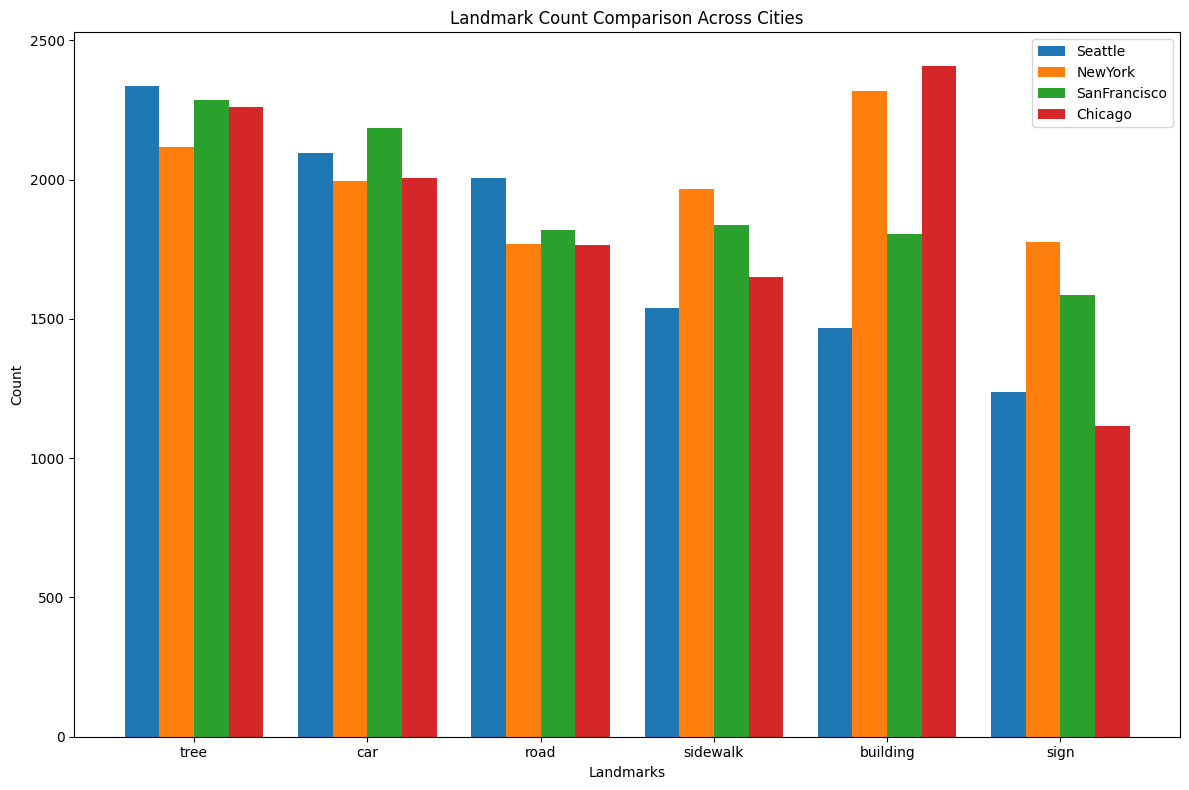

In [16]:

cities = list(city_panorama_landmarks.keys())
landmarks = list(next(iter(city_panorama_landmarks.values())).keys())

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(landmarks))

for i, city in enumerate(cities):
    counts = [city_panorama_landmarks[city][landmark] for landmark in landmarks]
    ax.bar(index + i * bar_width, counts, width=bar_width, label=city)

ax.set_xlabel('Landmarks')
ax.set_ylabel('Count')
ax.set_title('Landmark Count Comparison Across Cities')
ax.set_xticks(index + bar_width * (len(cities) - 1) / 2)
ax.set_xticklabels(landmarks)
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
from transformers import BertTokenizer, BertModel
import torch

# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/home/raymondlab/anaconda3/envs/huggingface_llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

batch_size = 64
city_dict = {}

for city in tqdm(df['city'].unique(), desc="Processing cities"):

    city_data = df[df['city'] == city]

    satellite_texts = []
    panorama_texts = []

    # Pre-read all files
    for i, row in city_data.iterrows():
        try:
            sat_path = os.path.join('results/satellite', model_id, city, 'satellite', row['satellite'].replace('.png', '.txt'))
            pan_path = os.path.join('results/panorama', model_id, city, 'panorama', row['panorama'].replace('.jpg', '.txt'))

            with open(sat_path, 'r') as f:
                satellite_texts.append(f.read())
            with open(pan_path, 'r') as f:
                panorama_texts.append(f.read())

        except Exception as e:
            print(f"Error reading {sat_path} or {pan_path}: {e}")

    satellite_embeddings = []
    panorama_embeddings = []

    # Batch inference
    for i in range(0, len(satellite_texts), batch_size):
        batch_sat = satellite_texts[i:i + batch_size]
        batch_pan = panorama_texts[i:i + batch_size]

        inputs_sat = tokenizer(batch_sat, return_tensors='pt', truncation=True, max_length=256, padding=True).to(device)
        inputs_pan = tokenizer(batch_pan, return_tensors='pt', truncation=True, max_length=256, padding=True).to(device)

        with torch.no_grad():
            outputs_sat = model(**inputs_sat).last_hidden_state[:, 0, :].cpu().numpy()
            outputs_pan = model(**inputs_pan).last_hidden_state[:, 0, :].cpu().numpy()

        satellite_embeddings.append(outputs_sat)
        panorama_embeddings.append(outputs_pan)

    # Concatenate all batches
    satellite_all = np.vstack(satellite_embeddings)
    panorama_all = np.vstack(panorama_embeddings)

    city_dict[city] = {'satellite': satellite_all, 'panorama': panorama_all}

print(f"Running on: {device}")


Processing cities: 100%|██████████| 4/4 [01:07<00:00, 16.93s/it]

Running on: cuda


In [19]:
compressed_dict = {
    city: {
        'satellite': np.array(
            [v['value'] if isinstance(v, dict) else v for v in city_dict[city]['satellite']],
            dtype=np.float16
        ),
        'panorama': np.array(
            [v['value'] if isinstance(v, dict) else v for v in city_dict[city]['panorama']],
            dtype=np.float16
        )
    }
    for city in city_dict
}

np.savez_compressed("results/city_dict_compressed.npz", **compressed_dict)


In [20]:
# code to load the compressed data

data = np.load("results/city_dict_compressed.npz", allow_pickle=True)

loaded_city_dict = {
    city: data[city].item()  # Convert from numpy object to Python dict
    for city in data.files
}
